In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Importing important libraries

In [2]:
import tensorflow as tf

C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\pyth

In [3]:
import os
import random
import numpy as np
from tqdm import tqdm

In [4]:
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

## Unzipping the files

In [5]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "stage1_train.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_train") 
    print('Done!') 

Extracting all the files now...
Done!


In [6]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "stage1_test.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
     
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("stage1_test") 
    print('Done!') 

Extracting all the files now...
Done!


## Performing preprocessing, Loading the data, and Getting data ready for our model

In [7]:
TRAIN_PATH="stage1_train/"
TEST_PATH='stage1_test/'

In [8]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]

In [9]:
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

In [10]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


  8%|▊         | 5/65 [00:00<00:01, 46.21it/s]

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 35.01it/s]

Done!


## Having a look at our training images and the segmented images related to it respectively

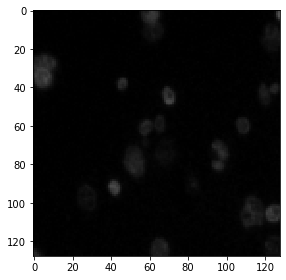

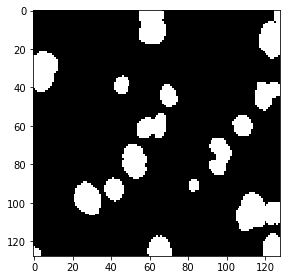

In [11]:
image_x=random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))

plt.show()

In [12]:
seed=42
np.random.seed=seed

## Building a U-Net

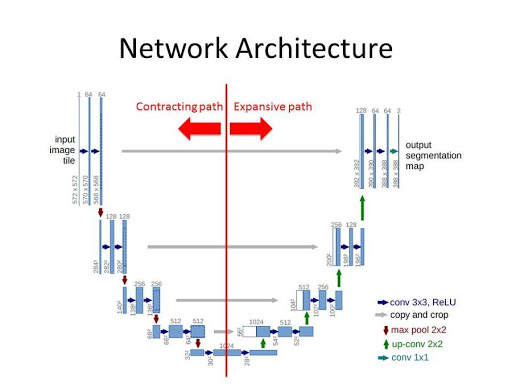

### Introduction:
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

The U-Net architecture stems from the so-called “fully convolutional network” first proposed by Long and Shelhamer.

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.

One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture. The network only uses the valid part of each convolution without any fully connected layers. To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. This tiling strategy is important to apply the network to large images, since otherwise the resolution would be limited by the GPU memory.

In [13]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
________________________________________________________________________________

In [14]:
#callbacks
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]

## Training the model

In [15]:
results=model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=30,callbacks=callbacks)

Train on 603 samples, validate on 67 samples
Epoch 1/30
603/603 [==============================] - 32s 53ms/sample - loss: 0.5245 - acc: 0.7805 - val_loss: 0.2660 - val_acc: 0.8162
Epoch 2/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.2541 - acc: 0.8686 - val_loss: 0.1632 - val_acc: 0.9395
Epoch 3/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.1817 - acc: 0.9337 - val_loss: 0.1386 - val_acc: 0.9443
Epoch 4/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.1450 - acc: 0.9456 - val_loss: 0.1319 - val_acc: 0.9459
Epoch 5/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.1377 - acc: 0.9480 - val_loss: 0.1136 - val_acc: 0.9536
Epoch 6/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.1318 - acc: 0.9500 - val_loss: 0.1186 - val_acc: 0.9536
Epoch 7/30
603/603 [==============================] - 18s 30ms/sample - loss: 0.1186 - acc: 0.9559 - val_loss: 0.1331 - val_acc: 0.9507


## Applying the segmentation on the test images using our trained model.

In [16]:
predict_test=model.predict(X_test,verbose=1)

65/65 [==============================] - 4s 61ms/sample


In [17]:
predict_test_t=(predict_test>0.5).astype(np.uint8)

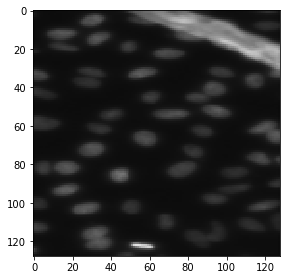

C:\Users\hp\anaconda3\envs\PythonGPU\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


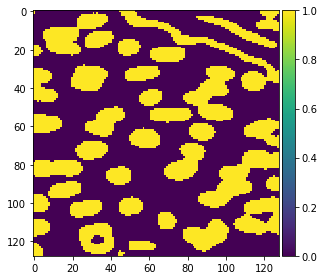

In [18]:
imshow(X_test[1])
plt.show()
imshow(np.squeeze(predict_test_t[1]))
plt.show()

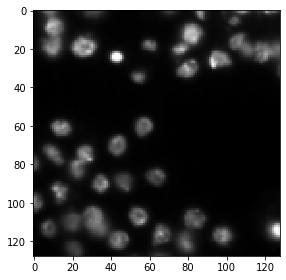

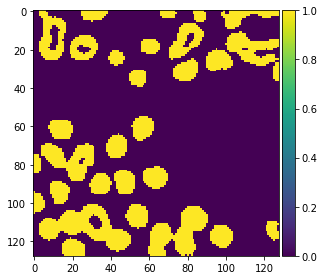

In [19]:
imshow(X_test[2])
plt.show()
imshow(np.squeeze(predict_test_t[2]))
plt.show()

In [20]:
print("Thank you!!")

Thank you!!
